# 自分で実装

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import linalg as LA

リカッチ代数方程式
$$
PA+A^{\top}P-PBR^{-1}B^{\top}P+Q=0
$$
の正定解$P$を求める．  

In [91]:
A = np.array([
    [1.1, 2],
    [-0.3, -1],
])
B = np.array([
    [1, 2],
    [0.847, 3],
])
Q = np.diag([10.0, 10.0])
R = np.diag([1., 1.])

P_solver = LA.solve_continuous_are(A, B, Q, R)
P_solver  # ソルバを使って求めた解

array([[ 3.34568216, -1.07265801],
       [-1.07265801,  1.30235279]])

# リカッチの非線形行列微分方程式を解いて求める
[教科書](#1)のp.160にある方法．力技．こちらは簡単．  

In [92]:
def solve_care(A, B, Q, R):
    P = np.zeros_like(A)
    P_ = P.copy()
    
    invR = np.linalg.inv(R)
    
    while True:
        P += (P @ A + A.T @ P - P @ B @ invR @ B.T @ P + Q) * 0.001
        if np.abs(P - P_).max() < 1e-12:
            break
        P_ = P.copy()
    
    return P


P = solve_care(A, B, Q, R)
P

array([[ 3.34568216, -1.07265801],
       [-1.07265801,  1.30235279]])

scipyの結果と比較

In [93]:
P - P_solver

array([[-1.81811899e-10,  7.89479593e-11],
       [ 7.89479593e-11, -3.42814666e-11]])

ほぼ同じ．

****
## 有本・ポッターの方法
[教科書](#1)のp.160にある方法．  
まずはハミルトン行列$H$をつくる．  
$$
H = \begin{bmatrix}
A & -BR^{-1}B^{\top}\\
-Q & -A^{\top}
\end{bmatrix}
$$

In [94]:
H = np.block([
    [A, -B @ np.linalg.inv(R) @ B.T],
    [-Q, -A.T],
])
H

array([[  1.1     ,   2.      ,  -5.      ,  -6.847   ],
       [ -0.3     ,  -1.      ,  -6.847   ,  -9.717409],
       [-10.      ,  -0.      ,  -1.1     ,   0.3     ],
       [ -0.      , -10.      ,  -2.      ,   1.      ]])

ハミルトン行列の固有値，固有ベクトルを求める．  

Text(0, 0.5, 'Im')

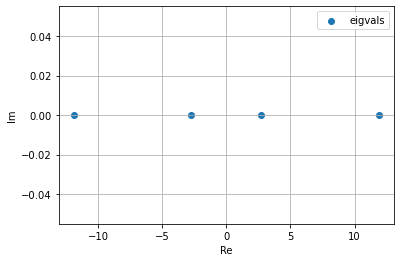

In [95]:
L, W = np.linalg.eig(H)  # 固有値と固有ベクトル

plt.scatter(np.real(L), np.imag(L), label="eigvals")
plt.legend(); plt.grid()
plt.xlabel("Re"); plt.ylabel("Im")

最適極は左半面にあるもの全てである．
今回は-11.86...と-2.73...の２つが最適極となる．  
$i$番目の最適極の固有ベクトル$\omega_i$を2つに分割する．  
$$
\omega_i = \begin{bmatrix}
u_i\\
v_i
\end{bmatrix}
$$

In [96]:
L

array([-11.86244676,  -2.73247999,   2.73247999,  11.86244676])

In [97]:
W

array([[ 0.30455389, -0.10098247,  0.31818607, -0.57472618],
       [ 0.70135795,  0.36076402,  0.06773247, -0.54094263],
       [ 0.26662328, -0.72483166, -0.78949562,  0.45297307],
       [ 0.58673332,  0.57816168,  0.52044847,  0.41459169]])

In [98]:
# -11.16...について
w1 = W[:, 0:1]
u1 = w1[:2, :]
v1 = w1[2:, :]

# -2.13...について
w2 = W[:, 1:2]
u2 = w2[:2, :]
v2 = w2[2:, :]

リカッチ解は次式となる．  
$$
P = [v_1, v_2, ...,v_n][u_1, u_2, ...,u_n]^{-1}
$$

In [99]:
U = np.block([u1, u2])
V = np.block([v1, v2])
P_ap = V @ np.linalg.inv(U)
P_ap

array([[ 3.34568216, -1.07265801],
       [-1.07265801,  1.30235279]])

ソルバー解と比較

In [100]:
P_ap - P_solver

array([[-3.55271368e-15, -4.44089210e-16],
       [ 2.22044605e-15,  4.44089210e-16]])

以上を１つの関数にまとめたもの⇓

In [101]:
def arimoto_potter(A, B, Q, R):
    """有本・ポッターの方法"""
    n = len(A)
    H = np.block([
        [A, -B @ np.linalg.inv(R) @ B.T],
        [-Q, -A.T],
    ])  # ハミルトン行列
    
    L, W = np.linalg.eig(H)  # 固有値と固有ベクトル
    U, V = [], []
    for i, l in enumerate(L):
        if np.real(l) < 0:  # 固有値が負の最適極の場合
            U.append(W[:n, i:i+1])
            V.append(W[n:, i:i+1])
    U = np.concatenate(U, axis=1)
    V = np.concatenate(V, axis=1)
    
    return V @ np.linalg.inv(U)